- Name: **Bidit Sadhukhan**



- Reg-B2230022, BDA
-  Assignment on Stock Price Data

In [7]:
!pip install yfinance

In [8]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import math
import datetime as dt
import urllib.request, json
import os
import yfinance as yf
import numpy as np
import tensorflow as tf
from tensorflow import keras # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

In [9]:
# import yfinance as yf
# from sklearn.preprocessing import MinMaxScaler

# google = yf.Ticker("GOOG")
# google.info

# data_download = yf.download("GOOG", start="2017-01-01", end="2023-04-30",
#                    group_by="ticker")

# data_download.values.shape
# plt.figure(figsize=(16,6))
# plt.plot(data_download['Open'])

# open = data_download['Open'].to_numpy()
# close = data_download['Close'].to_numpy()

# #data = close
# data=np.transpose(np.array([close]))

# len(data)
# train_len=math.ceil(len(data)*0.92)

[*********************100%%**********************]  1 of 1 completed


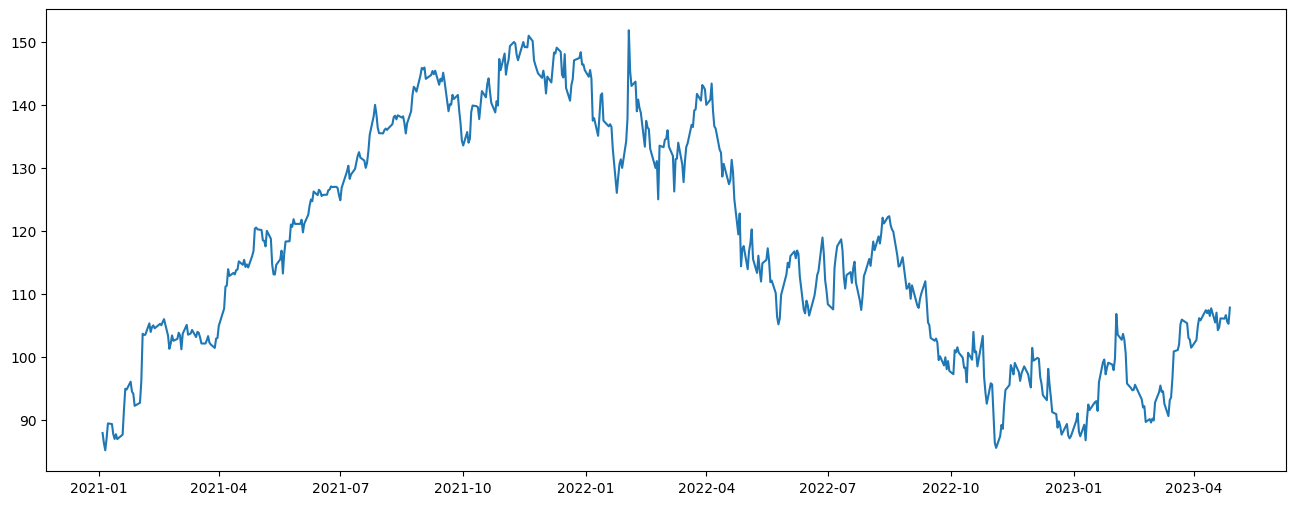

In [10]:


data_download = yf.download("GOOG", start="2021-01-01", end="2023-04-30",
                   group_by="ticker")

data_download.values.shape
plt.figure(figsize=(16,6))
plt.plot(data_download['Open'])

open = data_download['Open'].to_numpy()
close = data_download['Close'].to_numpy()

#data = close
data=np.transpose(np.array([close]))

len(data)
train_len=math.ceil(len(data)*0.92)





min_max_scalar=MinMaxScaler(feature_range=(0,1))
scaled_data=min_max_scalar.fit_transform(data);

len(scaled_data)

train_data=scaled_data[0:train_len,:];
len(train_data)
interval=90
x_train=[]
y_train=[]

for i in range(interval,len(train_data)):
    x_train.append(train_data[i-interval:i,0])
    y_train.append(train_data[i,0])


x_train,y_train=np.array(x_train),np.array(y_train);
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1));

Prediction using RNN

In [11]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

model = Sequential()
model.add(SimpleRNN(100, activation='relu', input_shape=(interval, 1)))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
%%time
model.fit(x_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
7/7 [==============================] - 6s 23ms/step - loss: 0.0350
Epoch 2/100
7/7 [==============================] - 0s 21ms/step - loss: 0.0051
Epoch 3/100
7/7 [==============================] - 0s 25ms/step - loss: 0.0035
Epoch 4/100
7/7 [==============================] - 0s 23ms/step - loss: 0.0025
Epoch 5/100
7/7 [==============================] - 0s 21ms/step - loss: 0.0020
Epoch 6/100
7/7 [==============================] - 0s 21ms/step - loss: 0.0018
Epoch 7/100
7/7 [==============================] - 0s 20ms/step - loss: 0.0017
Epoch 8/100
7/7 [==============================] - 0s 21ms/step - loss: 0.0016
Epoch 9/100
7/7 [==============================] - 0s 24ms/step - loss: 0.0016
Epoch 10/100
7/7 [==============================] - 0s 24ms/step - loss: 0.0016
Epoch 11/100
7/7 [==============================] - 0s 23ms/step - loss: 0.0016
Epoch 12/100
7/7 [==============================] - 0s 21ms/step - loss: 0.0016
Epoch 13/100
7/7 [==============================]

In [13]:
# Create a test dataset
test_data = scaled_data[train_len - interval:, :]
x_test = []
y_test = data[train_len:, :]

for i in range(interval, len(test_data)):
    x_test.append(test_data[i - interval:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [14]:
# Get predictions
predictions = model.predict(x_test)
predictions = min_max_scalar.inverse_transform(predictions)


2/2 [==============================] - 0s 13ms/step


In [15]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 3.8403055820659655


In [16]:
valid_data = y_test
valid_predictions = predictions
#print (train.shape)
print(data.shape)
print(valid_predictions.shape)
print(valid_data.shape)

(584, 1)
(46, 1)
(46, 1)


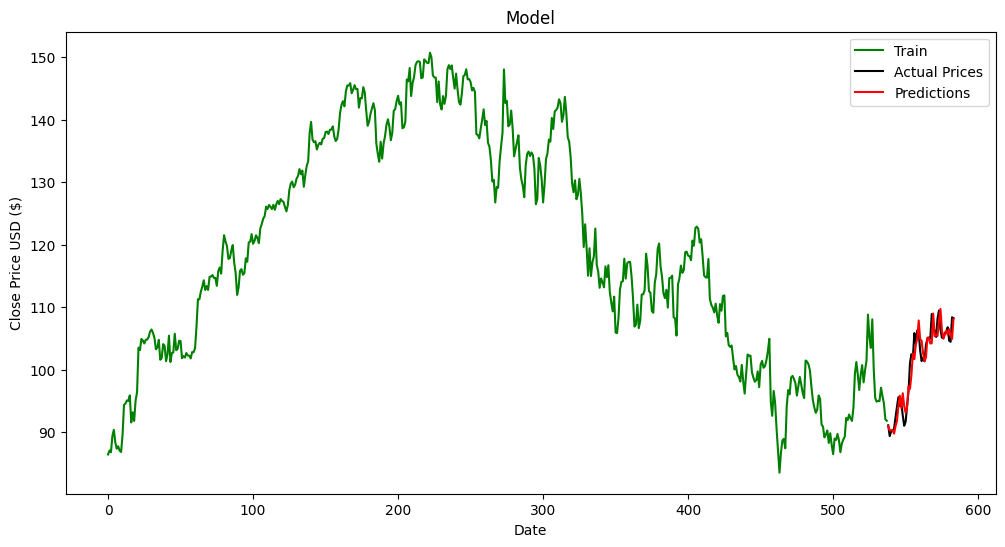

In [17]:
# Plot the results
train = data[:train_len]
valid_data = y_test
valid_predictions = predictions

shift_value = train_len  # Adjust this value as needed

# Create an adjusted x-axis range
x_range = np.arange(len(valid_data)) + shift_value


plt.figure(figsize=(12, 6))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train,color='green',label='Train')
plt.plot(x_range,valid_data, label='Actual Prices',color='black')
plt.plot(x_range,valid_predictions, label='Predictions',color='red')
plt.legend()
plt.show()


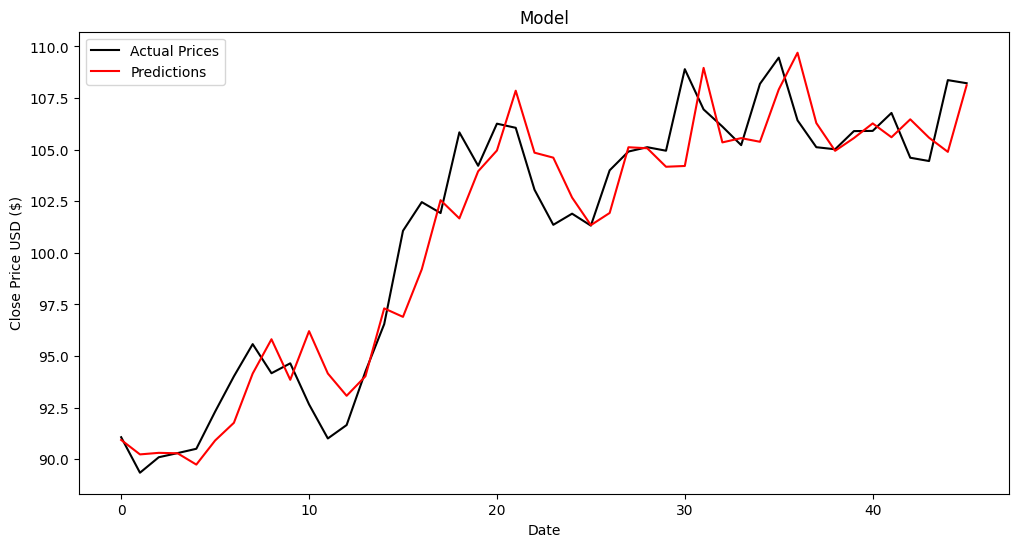

In [18]:
plt.figure(figsize=(12, 6))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(valid_data, label='Actual Prices',color='black')
plt.plot(valid_predictions, label='Predictions',color='red')
plt.legend()
plt.show()

Predictions using the RNN with attention

In [188]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
model = keras.Sequential()

# RNN layer with return_sequences=True to output a sequence of hidden states
model.add(keras.layers.SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1),kernel_initializer='he_normal'))

# Custom attention layer
class AttentionLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="attention_weight", shape=(input_shape[-1], 1), initializer="he_normal", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.matmul(x, self.W)
        a = keras.layers.Softmax(axis=1)(e)
        weighted_input = keras.layers.Multiply()([a, x])
        return tf.reduce_sum(weighted_input, axis=1)

model.add(AttentionLayer())
#optimizer = keras.optimizers.Adam(learning_rate=0.0001)
# Output layer
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [199]:
# Train the model
%%time
seed=42
np.random.seed(seed)
model.fit(x_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
7/7 [==============================] - 0s 72ms/step - loss: 0.0114
Epoch 2/100
7/7 [==============================] - 1s 71ms/step - loss: 0.0106
Epoch 3/100
7/7 [==============================] - 0s 58ms/step - loss: 0.0090
Epoch 4/100
7/7 [==============================] - 0s 43ms/step - loss: 0.0091
Epoch 5/100
7/7 [==============================] - 0s 42ms/step - loss: 0.0107
Epoch 6/100
7/7 [==============================] - 0s 44ms/step - loss: 0.0106
Epoch 7/100
7/7 [==============================] - 0s 42ms/step - loss: 0.0098
Epoch 8/100
7/7 [==============================] - 0s 42ms/step - loss: 0.0092
Epoch 9/100
7/7 [==============================] - 0s 41ms/step - loss: 0.0093
Epoch 10/100
7/7 [==============================] - 0s 40ms/step - loss: 0.0085
Epoch 11/100
7/7 [==============================] - 0s 42ms/step - loss: 0.0084
Epoch 12/100
7/7 [==============================] - 0s 43ms/step - loss: 0.0079
Epoch 13/100
7/7 [==============================]

In [200]:
# Get predictions
predictions = model.predict(x_test)
predictions = min_max_scalar.inverse_transform(predictions)


2/2 [==============================] - 0s 16ms/step


In [201]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 17.914314075750198


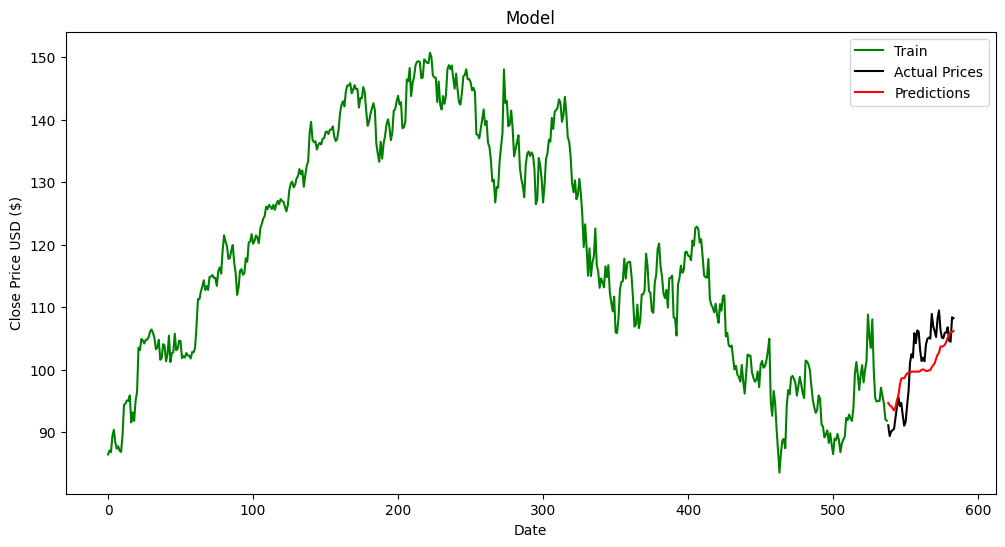

In [202]:
# Plot the results
train = data[:train_len]
valid_data = y_test
valid_predictions = predictions

shift_value = train_len  # Adjust this value as needed

# Create an adjusted x-axis range
x_range = np.arange(len(valid_data)) + shift_value


plt.figure(figsize=(12, 6))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train,color='green',label='Train')
plt.plot(x_range,valid_data, label='Actual Prices',color='black')
plt.plot(x_range,valid_predictions, label='Predictions',color='red')
plt.legend()
plt.show()


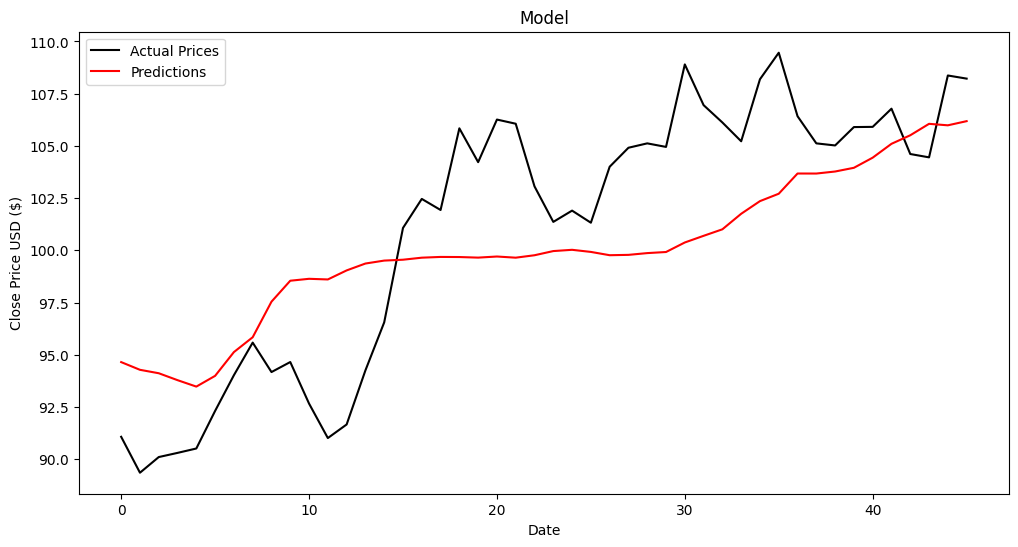

In [203]:
plt.figure(figsize=(12, 6))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(valid_data, label='Actual Prices',color='black')
plt.plot(valid_predictions, label='Predictions',color='red')
plt.legend()
plt.show()

Predictions using CNN and RNN

In [97]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
model = keras.Sequential()
# Convolutional layers
model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=2))

# RNN layer (LSTM in this example)
model.add(keras.layers.LSTM(50, activation='relu', return_sequences=False))

# Output layer
model.add(keras.layers.Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [99]:
# Train the model
%%time
np.random.seed(seed)
model.fit(x_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
7/7 [==============================] - 2s 24ms/step - loss: 0.2323
Epoch 2/100
7/7 [==============================] - 0s 23ms/step - loss: 0.0443
Epoch 3/100
7/7 [==============================] - 0s 21ms/step - loss: 0.0276
Epoch 4/100
7/7 [==============================] - 0s 20ms/step - loss: 0.0191
Epoch 5/100
7/7 [==============================] - 0s 27ms/step - loss: 0.0132
Epoch 6/100
7/7 [==============================] - 0s 34ms/step - loss: 0.0117
Epoch 7/100
7/7 [==============================] - 0s 35ms/step - loss: 0.0105
Epoch 8/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0097
Epoch 9/100
7/7 [==============================] - 0s 34ms/step - loss: 0.0092
Epoch 10/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0087
Epoch 11/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0085
Epoch 12/100
7/7 [==============================] - 0s 37ms/step - loss: 0.0083
Epoch 13/100
7/7 [==============================]

In [100]:
# Get predictions
predictions = model.predict(x_test)

predictions = min_max_scalar.inverse_transform(predictions)




2/2 [==============================] - 0s 11ms/step


In [101]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 11.058537150302943


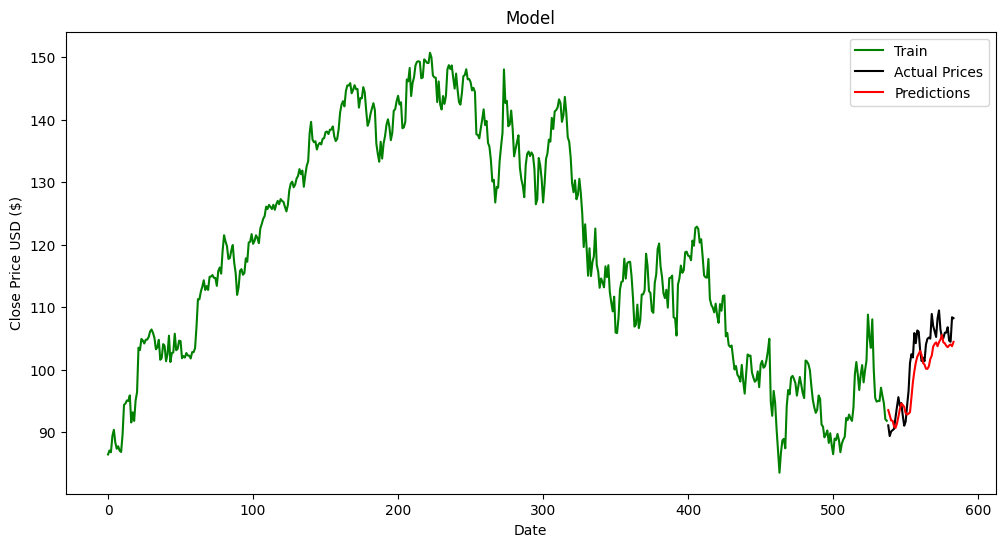

In [102]:
# Plot the results
train = data[:train_len]
valid_data = y_test
valid_predictions = predictions

shift_value = train_len  # Adjust this value as needed

# Create an adjusted x-axis range
x_range = np.arange(len(valid_data)) + shift_value


plt.figure(figsize=(12, 6))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train,color='green',label='Train')
plt.plot(x_range,valid_data, label='Actual Prices',color='black')
plt.plot(x_range,valid_predictions, label='Predictions',color='red')
plt.legend()
plt.show()


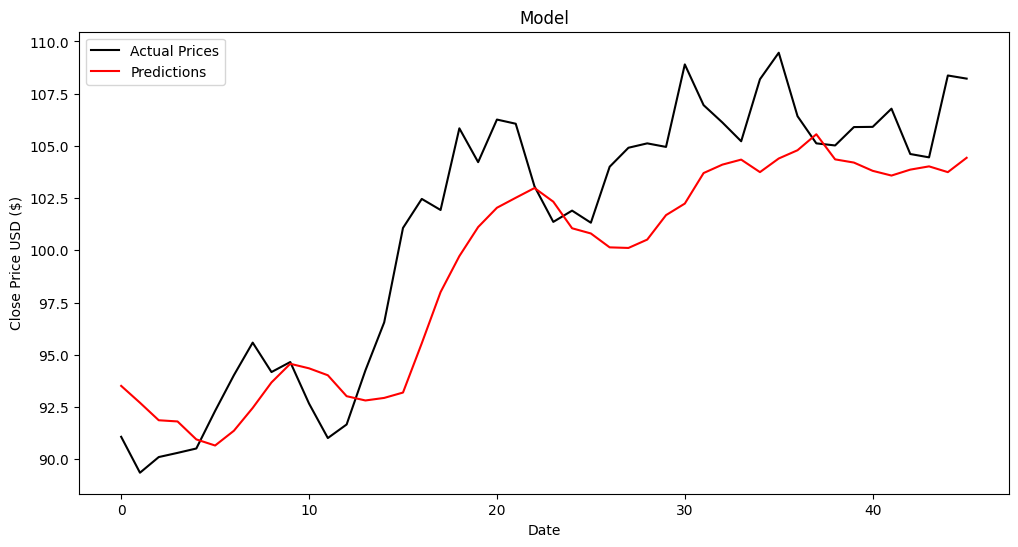

In [103]:
plt.figure(figsize=(12, 6))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(valid_data, label='Actual Prices',color='black')
plt.plot(valid_predictions, label='Predictions',color='red')
plt.legend()
plt.show()

RNN with Time2Vec

In [62]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

class Time2VecLayer(keras.layers.Layer):
    def __init__(self, num_units, **kwargs):
        super(Time2VecLayer, self).__init__(**kwargs)
        self.num_units = num_units

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], self.num_units), initializer='uniform', trainable=True)
        self.P = self.add_weight(shape=(input_shape[-1], self.num_units), initializer='uniform', trainable=True)
        self.bias = self.add_weight(shape=(self.num_units,), initializer='uniform', trainable=True)
        super(Time2VecLayer, self).build(input_shape)

    def call(self, inputs):
        x = inputs
        sin_trans = keras.backend.sin(keras.backend.dot(x, self.W) + self.bias)
        cos_trans = keras.backend.cos(keras.backend.dot(x, self.P) + self.bias)
        return keras.backend.concatenate([sin_trans, cos_trans], axis=-1)

# Create the RNN with Time2Vec model
input_layer = keras.layers.Input(shape=(x_train.shape[1], 1))  # Define input shape
time2vec_output = Time2VecLayer(num_units=32)(input_layer)  # Apply Time2Vec layer
lstm_output = keras.layers.LSTM(64, return_sequences=False)(time2vec_output)  # Apply LSTM layer
output_layer = keras.layers.Dense(1)(lstm_output)  # Output layer

model = keras.models.Model(inputs=input_layer, outputs=output_layer)
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 90, 1)]           0         
                                                                 
 time2_vec_layer_7 (Time2Ve  (None, 90, 64)            96        
 cLayer)                                                         
                                                                 
 lstm_8 (LSTM)               (None, 64)                33024     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 33185 (129.63 KB)
Trainable params: 33185 (129.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
# Train the model
%%time
model.fit(x_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
7/7 [==============================] - 2s 10ms/step - loss: 0.1887
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0865
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0721
Epoch 4/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0703
Epoch 5/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0617
Epoch 6/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0571
Epoch 7/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0492
Epoch 8/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0403
Epoch 9/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0288
Epoch 10/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0146
Epoch 11/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0062
Epoch 12/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 13/100
7/7 [==============================] - 0s 6ms/s

In [65]:
# Get predictions
predictions = model.predict(x_test)

predictions = min_max_scalar.inverse_transform(predictions)




2/2 [==============================] - 0s 7ms/step


In [66]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 4.427066932704411


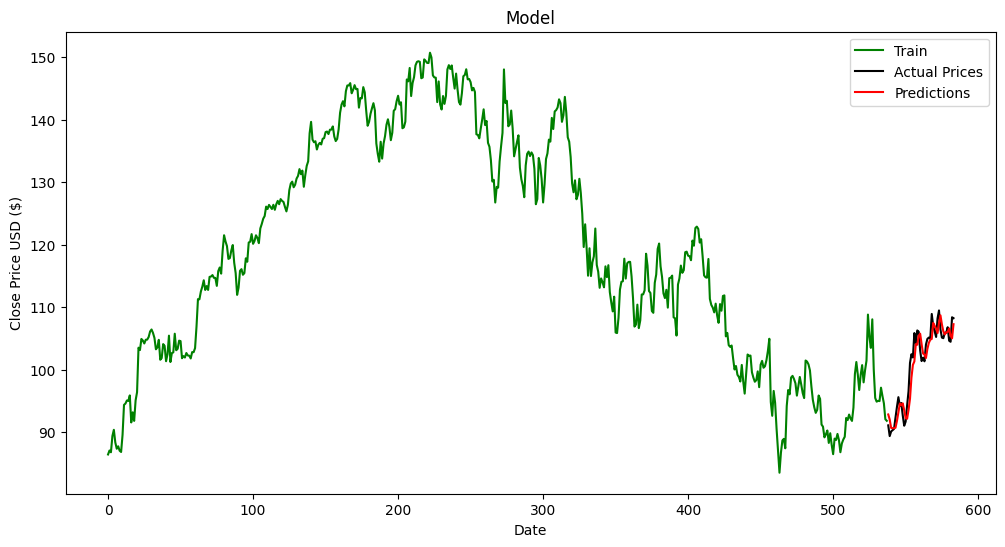

In [67]:
# Plot the results
train = data[:train_len]
valid_data = y_test
valid_predictions = predictions

shift_value = train_len  # Adjust this value as needed

# Create an adjusted x-axis range
x_range = np.arange(len(valid_data)) + shift_value


plt.figure(figsize=(12, 6))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train,color='green',label='Train')
plt.plot(x_range,valid_data, label='Actual Prices',color='black')
plt.plot(x_range,valid_predictions, label='Predictions',color='red')
plt.legend()
plt.show()


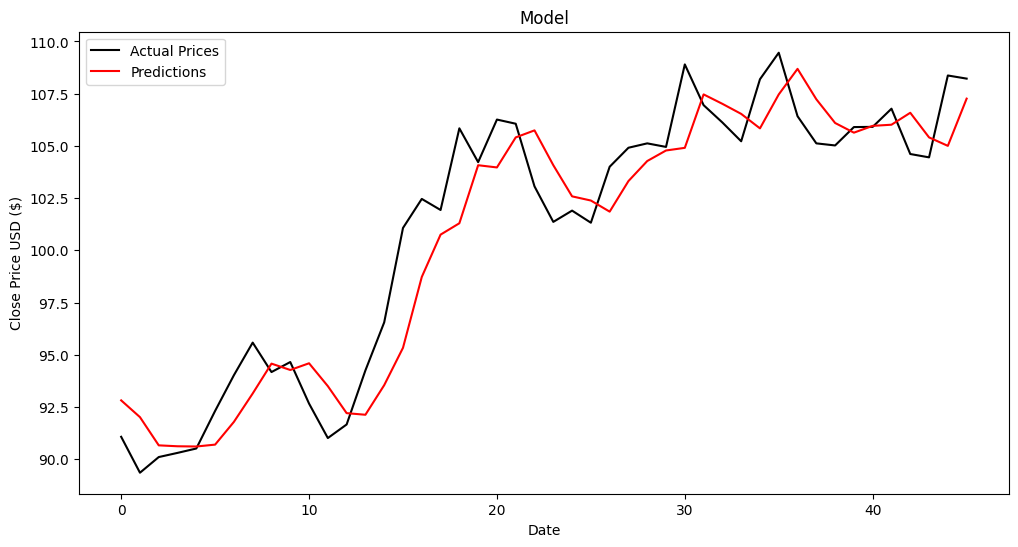

In [68]:
plt.figure(figsize=(12, 6))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(valid_data, label='Actual Prices',color='black')
plt.plot(valid_predictions, label='Predictions',color='red')
plt.legend()
plt.show()